## Многоуровнеывый эстиматор
Порызмыслив я понял, что собираемый в предыдущих изысканиях тренировачные данные не покрывают и малой доли всего того объема, который требуется, чтобы получить на выходе алгоритм с хорошей генеративной способностью.

Дело в том, что при нахождении устройства в одном положении сигналы со сканеров могут прилетать в любой последовательности с некоторым разбросом значений. Если данные со всех сканеров группировать в один вектор в единицу времени, то получится, что для покрытия всех возможных вариантов нужно перебрать все возможные комбинации значений со всех сканеров, а это очень много (???). 

Отсюда возникла идея – что если построить эстиматор для каждого сканеро, которые будет для каждого сканера предсказывать в каком помещении сейчас находится устройство (таким образом эстиматор покроет все множество возможных значений для конкретного сканера) и уже на основе выхода со всех эстиматоров от всех сканеров построить еще один эстиматор, который будет принимать решение где находится устройство. Понятно, что эстиматоры для сканеров будут часто ошибаться, но эстиматор над ними будет призван исправить положение.

In [1]:
from server import config
from datetime import datetime
import asyncio
from itertools import product
from collections import defaultdict
from asyncio_mqtt import Client, MqttError
from contextlib import AsyncExitStack
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing, metrics, linear_model, multiclass, feature_selection, pipeline
from sklearn.cluster import MeanShift
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif, SelectorMixin
from sklearn.base import TransformerMixin, BaseEstimator
from server.heartbeat import HeratbeatGenerator
from joblib import Parallel, delayed
import xgboost
import pandas as pd
import numpy as np
import seaborn as sbs
from matplotlib import pyplot as plt
import jsons
from server.kalman import KalmanRSSI

pd.set_option('display.float_format', '{:.4f}'.format)

## Upsampling per position
Для каждой позиции засемплируем сигналы от каждого сканера, если сигналов было больше 10. Засемплируем до 200 сигналов. Это позволит получить достаточно данных, чтобы накатить на rssi разные методы сглаживания: kalman и ma

In [2]:
data_df = pd.read_csv('./signals.csv')
data_df['when'] = data_df['when'].astype('datetime64')
data_df['when_ts'] = data_df['when'].apply(lambda x: (x - np.datetime64('1970-01-01T00:00:00')) / np.timedelta64(1, 's'))
data_df['rssi_bin'] = pd.cut(data_df['rssi'], np.arange(-100, 0, 5))

In [3]:
upsampled_data_df = []
for scanner in data_df['scanner'].unique():
    scanner_df = data_df.loc[data_df['scanner'] == scanner]
    upsampled_scanner_df = []

    for position in scanner_df['position'].unique():
        position_signals_df = scanner_df.loc[scanner_df['position'] == position]
        if len(position_signals_df) < 4:
            # print('Scanner "{}" excluded from position "{}", {} signals'.format(scanner, position, len(position_signals_df)))
            continue
        position_signals_df = position_signals_df.sample(n=200, replace=True, ignore_index=True)
        upsampled_scanner_df.append(position_signals_df[['rssi', 'when_ts', 'rssi_bin', 'scanner', 'position', 'room']])

    upsampled_scanner_df = pd.concat(upsampled_scanner_df)
    upsampled_data_df.append(upsampled_scanner_df)
    
upsampled_data_df = pd.concat(upsampled_data_df).reset_index()
upsampled_data_df['index'] = upsampled_data_df.groupby(['scanner', 'position']).cumcount()

In [4]:
for position in upsampled_data_df['position'].unique():
    print('>', position)
    print(upsampled_data_df.loc[upsampled_data_df['position'] == position]['scanner'].value_counts())

> office-1637221275.029067
office      200
bathroom    200
lobby       200
Name: scanner, dtype: int64
> office-1637221547.741976
office      200
bathroom    200
lobby       200
Name: scanner, dtype: int64
> office-1637222011.515473
office      200
bathroom    200
lobby       200
Name: scanner, dtype: int64
> bathroom-1637222116.619492
office      200
bathroom    200
lobby       200
extra-1     200
Name: scanner, dtype: int64
> bathroom-1637222239.984954
office      200
bathroom    200
lobby       200
laundry     200
Name: scanner, dtype: int64
> bathroom-1637222436.5519
office      200
bathroom    200
lobby       200
laundry     200
Name: scanner, dtype: int64
> bathroom-1637222786.828138
office      200
bathroom    200
lobby       200
laundry     200
extra-1     200
Name: scanner, dtype: int64
> lobby-1637223026.962617
office      200
bathroom    200
laundry     200
Name: scanner, dtype: int64
> lobby-1637223092.839924
office      200
bathroom    200
lobby       200
laundry     200
g

## Smoothing
Сгладим сигналы разными способами, сравним результаты на линейном графике

In [5]:
smoothed_data_df = upsampled_data_df.copy()
smoothed_data_df['rssi_ma_2'] = smoothed_data_df.groupby(['scanner', 'position'])['rssi'].rolling(2).mean().reset_index((0,1))['rssi'].round(1)
smoothed_data_df['rssi_ma_5'] = smoothed_data_df.groupby(['scanner', 'position'])['rssi'].rolling(5).mean().reset_index((0,1))['rssi'].round(1)
smoothed_data_df['rssi_ma_10'] = smoothed_data_df.groupby(['scanner', 'position'])['rssi'].rolling(10).mean().reset_index((0,1))['rssi'].round(1)
smoothed_data_df.dropna(inplace=True)

In [6]:
kalman_filters = defaultdict(lambda: KalmanRSSI(R=0.15, Q=10))
smoothed_data_df['rssi_kalman'] = smoothed_data_df.groupby(['scanner', 'position']).apply(lambda x: x.apply(lambda y: pd.Series({**y, 'rssi': kalman_filters[(y['scanner'], y['position'])].filter(y['rssi']) }), axis=1))['rssi'].round()

In [25]:
smoothed_data_df.loc[smoothed_data_df['position'] == 'bedroom-1637225070.761705']['scanner'].unique()

array(['laundry', 'extra-1', 'kitchen', 'bedroom'], dtype=object)

<AxesSubplot:xlabel='index', ylabel='final_rssi'>

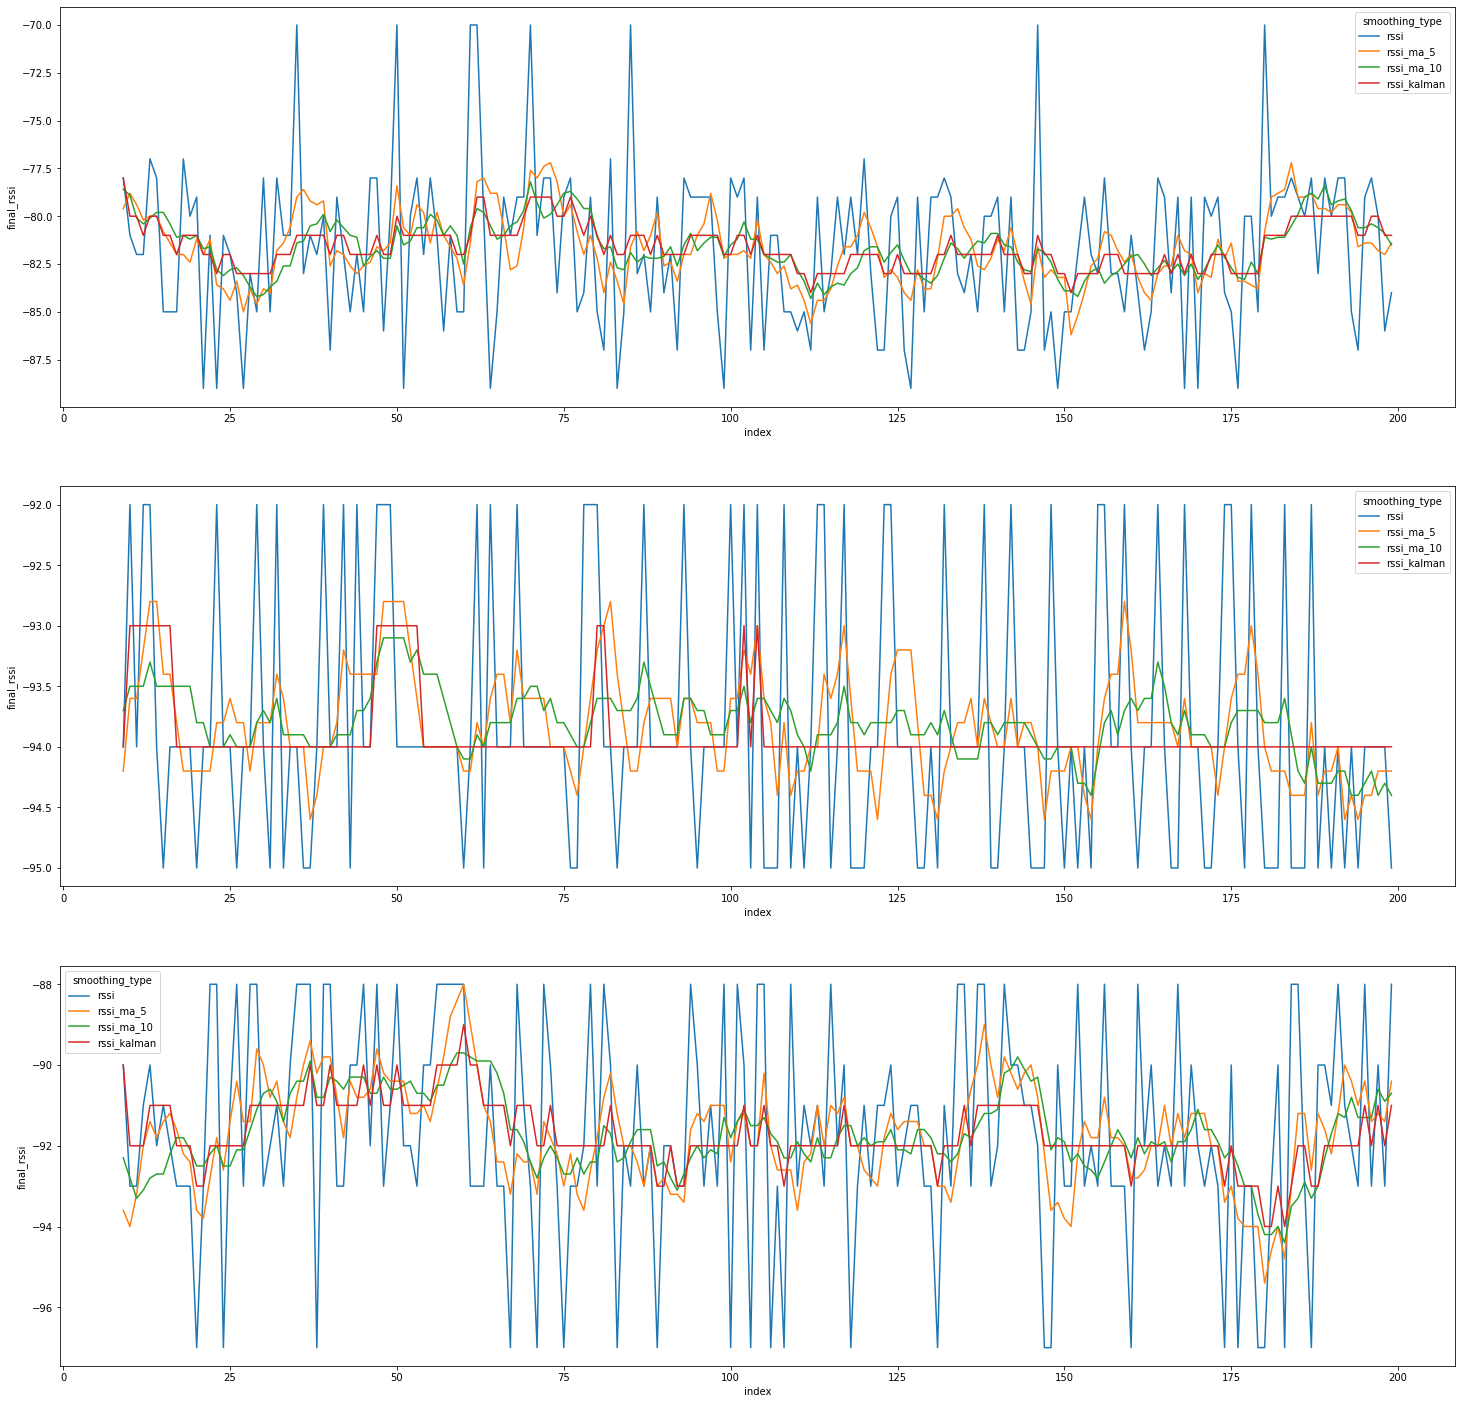

In [26]:
fig, axes = plt.subplots(3, 1, figsize=(25, 25))
smoothing_vis_data_df = smoothed_data_df[['scanner', 'position', 'room', 'index', 'rssi', 'rssi_ma_5', 'rssi_ma_10', 'rssi_kalman']].melt(
    id_vars=['room', 'scanner', 'position', 'index'], var_name='smoothing_type', value_name='final_rssi')
sbs.lineplot(
    x='index', y='final_rssi', ax=axes[0], hue='smoothing_type',
    data=smoothing_vis_data_df[(smoothing_vis_data_df['position'] == 'bedroom-1637225070.761705') & (smoothing_vis_data_df['scanner'].isin(['bedroom']))])
sbs.lineplot(
    x='index', y='final_rssi', ax=axes[1], hue='smoothing_type',
    data=smoothing_vis_data_df[(smoothing_vis_data_df['position'] == 'bedroom-1637225070.761705') & (smoothing_vis_data_df['scanner'].isin(['kitchen']))])
sbs.lineplot(
    x='index', y='final_rssi', ax=axes[2], hue='smoothing_type',
    data=smoothing_vis_data_df[(smoothing_vis_data_df['position'] == 'bedroom-1637225070.761705') & (smoothing_vis_data_df['scanner'].isin(['extra-1']))])

## Генерация heartbeats
Финальные данные, по которым будет приниматься решение о присутствии это все возможные сочетания различных значачений со сканеров в опрежеленной позиции. Сгенерируем эти данные и попробуем обучить модель на основе этих данных

In [9]:
heartbeats_df = []

for position in smoothed_data_df['position'].unique():
    position_df = smoothed_data_df.loc[smoothed_data_df['position'] == position]
    active_scanners = position_df['scanner'].unique()
    unique_scanner_rssi = [position_df.loc[position_df['scanner'] == scanner]['rssi_kalman'].unique().tolist() for scanner in active_scanners]
    position_heartbeats_df = pd.DataFrame(data=product(*unique_scanner_rssi), columns=active_scanners)
    position_heartbeats_df['_room'] = position_df.iloc[0]['position']
    # position_heartbeats_df['_position'] = position
    heartbeats_df.append(position_heartbeats_df)

heartbeats_df = pd.concat(heartbeats_df)[[*smoothed_data_df['scanner'].unique(), '_room']]
heartbeats_df.fillna(-100, inplace=True)
heartbeats_df.drop_duplicates(inplace=True)

In [10]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(heartbeats_df.iloc[:, :-1], heartbeats_df['_room'], stratify=heartbeats_df['_room'], random_state=42, test_size=0.5)
print('Training {}, testing {}'.format(str(len(y_train)), str(len(y_test))))

Training 161186, testing 161187


## Heartbeat predictions
Построим классификатор, который будет предсказывать положение по входящим хертбитам

In [15]:
class SelectHighestMean(SelectorMixin, BaseEstimator):
    def fit(self, X, y):
        self.means_ = np.mean(X[y == 1], axis=0)
        return self

    def _more_tags(self):
        return {'requires_y': True}

    def _get_support_mask(self):
        mask = np.zeros(self.means_.shape, dtype=bool)
        sorted_indexes = np.argsort(self.means_, kind="mergesort")
        mask[sorted_indexes[-4:]] = 1
        mask[self.means_ <= -95] = 0
        mask[sorted_indexes[-1:]] = 1
        return mask

In [11]:
scoring = {
    'accuracy': metrics.make_scorer(metrics.accuracy_score),
    'precision': metrics.make_scorer(metrics.precision_score, average = 'macro'),
    'recall': metrics.make_scorer(metrics.recall_score, average = 'macro'),
    'f1_macro': metrics.make_scorer(metrics.f1_score, average = 'macro'),
    'f1_weighted': metrics.make_scorer(metrics.f1_score, average = 'weighted')
}

In [43]:
class OneVsRestClassifierFiltered(multiclass.OneVsRestClassifier):
    pass

clf = pipeline.Pipeline([
    ('select', SelectHighestMean()),
    # ('scale', preprocessing.StandardScaler()),
    # ('select', SelectFromModel(linear_model.LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', C=0.01, max_iter=100000))),
    ('classification', RandomForestClassifier(n_estimators=5, class_weight='balanced', n_jobs=-1))
    # ('classification', linear_model.LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', C=0.001, max_iter=100000))
    # ('classification', KNeighborsClassifier(2))
])
xgb_estimator = OneVsRestClassifierFiltered(clf)
model_selection.cross_validate(xgb_estimator, X_train, y_train, cv=3, scoring=scoring)

{'fit_time': array([6.40865302, 4.91887879, 4.93504643]),
 'score_time': array([1.08797145, 1.08434534, 1.09558392]),
 'test_accuracy': array([0.99737572, 0.99711515, 0.99717094]),
 'test_precision': array([0.96174423, 0.96180943, 0.96491957]),
 'test_recall': array([0.96175201, 0.95624452, 0.95671284]),
 'test_f1_macro': array([0.96046273, 0.95678645, 0.95903668]),
 'test_f1_weighted': array([0.99737169, 0.99712822, 0.9971451 ])}

In [37]:
xgb_estimator.fit(X_train, y_train)
print(metrics.classification_report(y_test, xgb_estimator.predict(X_test)))

                            precision    recall  f1-score   support

bathroom-1637222116.619492       1.00      1.00      1.00       288
bathroom-1637222239.984954       1.00      1.00      1.00      1120
  bathroom-1637222436.5519       1.00      1.00      1.00       180
bathroom-1637222786.828138       0.97      0.98      0.97      1200
 bedroom-1637224899.441276       0.77      0.80      0.78       490
 bedroom-1637224994.274671       1.00      1.00      1.00       300
 bedroom-1637225070.761705       0.63      0.58      0.61       294
 bedroom-1637225191.428329       1.00      1.00      1.00      1920
   guest-1637224171.107522       1.00      1.00      1.00      1848
   guest-1637224240.792768       1.00      1.00      1.00       294
   guest-1637224320.916289       1.00      1.00      1.00       144
   guest-1637224418.349517       1.00      0.93      0.97      1400
   guest-1637224502.453198       1.00      1.00      1.00       672
   guest-1637224600.915573       1.00      1.00

In [40]:
xgb_estimator.label_binarizer_.classes_

array(['bathroom-1637222116.619492', 'bathroom-1637222239.984954',
       'bathroom-1637222436.5519', 'bathroom-1637222786.828138',
       'bedroom-1637224899.441276', 'bedroom-1637224994.274671',
       'bedroom-1637225070.761705', 'bedroom-1637225191.428329',
       'guest-1637224171.107522', 'guest-1637224240.792768',
       'guest-1637224320.916289', 'guest-1637224418.349517',
       'guest-1637224502.453198', 'guest-1637224600.915573',
       'guest-1637224782.246573', 'kitchen-1637223656.993929',
       'kitchen-1637223720.870339', 'kitchen-1637223759.627233',
       'kitchen-1637223827.555968', 'kitchen-1637223887.142044',
       'kitchen-1637223993.488225', 'kitchen-1637224053.476538',
       'laundry-1637223379.434914', 'laundry-1637223528.455919',
       'lobby-1637223026.962617', 'lobby-1637223092.839924',
       'lobby-1637223159.730842', 'lobby-1637223281.578186',
       'office-1637221275.029067', 'office-1637221547.741976',
       'office-1637222011.515473'], dtype='<U26

In [42]:
pred_probas = xgb_estimator.predict_proba(X_test)
sorted_rooms = xgb_estimator.classes_
pred_probas_df = pd.DataFrame(
    [dict(list(zip(sorted_rooms, r)) + [('_room', y_test.iloc[i])]) for i, r in enumerate(pred_probas)]).dropna()

for _, room in enumerate(sorted_rooms):
    y_true = [1 if x else 0 for x in pred_probas_df['_room'] == room]
    y_pred = list(pred_probas_df[room])
    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_pred)
    ix = np.argmax(recall)
    print('%s - Best Threshold=%f, Precision=%.3f, Recall=%.3f' % (
        room, thresholds[ix], precision[ix], recall[ix]))

/home/artem/development/blackhole/mqtt-room-presence/.venv/lib/python3.8/site-packages/sklearn/multiclass.py:422: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


bathroom-1637222116.619492 - Best Threshold=1.000000, Precision=1.000, Recall=1.000
bathroom-1637222239.984954 - Best Threshold=1.000000, Precision=1.000, Recall=1.000
bathroom-1637222436.5519 - Best Threshold=1.000000, Precision=1.000, Recall=1.000
bathroom-1637222786.828138 - Best Threshold=0.277111, Precision=0.857, Recall=1.000
bedroom-1637224899.441276 - Best Threshold=0.000000, Precision=0.003, Recall=1.000
bedroom-1637224994.274671 - Best Threshold=1.000000, Precision=1.000, Recall=1.000
bedroom-1637225070.761705 - Best Threshold=0.000000, Precision=0.002, Recall=1.000
bedroom-1637225191.428329 - Best Threshold=0.501543, Precision=1.000, Recall=1.000
guest-1637224171.107522 - Best Threshold=0.500615, Precision=1.000, Recall=1.000
guest-1637224240.792768 - Best Threshold=0.833333, Precision=1.000, Recall=1.000
guest-1637224320.916289 - Best Threshold=1.000000, Precision=1.000, Recall=1.000
guest-1637224418.349517 - Best Threshold=0.000000, Precision=0.009, Recall=1.000
guest-1637

## Per position predictions
Построим по модели для каждого сканера, чтобы распознать комнату или позицию.

In [83]:
estimators = {}
for scanner in smoothed_data_df['scanner'].unique()[:1]:
    scanner_df = smoothed_data_df.loc[smoothed_data_df['scanner'] == scanner]

    X, y = scanner_df.rssi_kalman.values.reshape(-1, 1), scanner_df.room.values
    X_train, X_test, y_train, y_test = model_selection.train_test_split(np.array(X), np.array(y), stratify=y, random_state=42, test_size=0.5)
    est = RandomForestClassifier(n_estimators=5, class_weight='balanced', n_jobs=-1)
    est.fit(X_train, y_train)
    estimators[scanner] = est

    y_pred = est.predict_proba(X_test)
    print(scanner, est.score(X_test, y_test), est.score(X_train, y_train))
    print(y_pred)

office 0.8087535680304472 0.8142857142857143
[[0.25549655 0.         0.74450345 0.        ]
 [0.         0.         0.         1.        ]
 [1.         0.         0.         0.        ]
 ...
 [0.25788371 0.         0.72985936 0.01225693]
 [0.0889132  0.9110868  0.         0.        ]
 [0.         0.         0.         1.        ]]


In [67]:
def _predict_scanner(rssi, estimator):
    return estimator.predict_proba([[rssi]])[0]

def _predict_row(row, estimators):
    pred_res = Parallel(n_jobs=5)(delayed(_predict_scanner)(row[scanner], estimator)
        for scanner, estimator in estimators.items())

    pred_row = {}
    for j, estimator in enumerate(estimators.values()):
        for i, v in enumerate(pred_res[j]):
            pred_row[estimator.classes_[i]] = pred_row.get(estimator.classes_[i], 0) + v

    pred_row['_room'] = row['_room']
    return pred_row

def predict(X):
    return pd.DataFrame(Parallel(n_jobs=-1)(delayed(_predict_row)(row, estimators)
        for _, row in X.iterrows()))

In [70]:
heartbeats_pred = predict(X_train)

KeyboardInterrupt: 

In [ ]:
precisions = []
for room in test_heartbeats_df['_room'].unique():
    y_true = list(test_heartbeats_df['_room'] == room)
    y_room_pred = heartbeats_pred[room].values
    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_room_pred)
    beta_squared = 2 ** 2
    fscore = ((1 + beta_squared) * precision * recall) / (beta_squared * precision + recall)
    ix = np.argmax(fscore)
    precisions.append(precision[ix])
    print('%s - Best Threshold=%f, Precision=%.3f, Recall=%.3f' % (room, thresholds[ix], precision[ix], recall[ix]))
print('\nMin Precision: {}\nAvg Precision: {}'.format(np.min(precisions), np.mean(precisions)))

guest - Best Threshold=1.573188, Precision=0.226, Recall=0.715
lobby - Best Threshold=1.571745, Precision=0.613, Recall=0.924
laundry - Best Threshold=0.980859, Precision=0.674, Recall=0.948
kitchen - Best Threshold=2.790187, Precision=0.649, Recall=0.851
bedroom - Best Threshold=2.421186, Precision=1.000, Recall=1.000
bathroom - Best Threshold=2.255317, Precision=0.415, Recall=0.818
office - Best Threshold=1.623801, Precision=0.900, Recall=0.750

Min Precision: 0.2261029411764706
Avg Precision: 0.6396162353738504


In [ ]:
next_data_df = heartbeats_pred.copy().drop_duplicates()
X, y = (next_data_df.iloc[:, :-1], next_data_df._room.values)
X_train, X_test, y_train, y_test = model_selection.train_test_split(np.array(X), np.array(y), stratify=y, random_state=42, test_size=0.2)
print('Training {}, testing {}'.format(str(len(y_train)), str(len(y_test))))

Training 3980, testing 995


In [ ]:
scoring = {
    'accuracy': metrics.make_scorer(metrics.accuracy_score),
    'precision': metrics.make_scorer(metrics.precision_score, average = 'macro'),
    'recall': metrics.make_scorer(metrics.recall_score, average = 'macro'),
    'f1_macro': metrics.make_scorer(metrics.f1_score, average = 'macro'),
    'f1_weighted': metrics.make_scorer(metrics.f1_score, average = 'weighted')
}

In [ ]:
xgb_estimator = RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1)
model_selection.cross_validate(xgb_estimator, X_train, y_train, cv=3, scoring=scoring)

{'fit_time': array([1.1318512 , 0.11020589, 0.10455871]),
 'score_time': array([0.09273529, 0.09088182, 0.09043574]),
 'test_accuracy': array([0.97889977, 0.97663904, 0.96455505]),
 'test_precision': array([0.99002919, 0.98634318, 0.9756662 ]),
 'test_recall': array([0.96902189, 0.95135881, 0.89344377]),
 'test_f1_macro': array([0.97893527, 0.96750384, 0.9267792 ]),
 'test_f1_weighted': array([0.97883807, 0.97638949, 0.9640453 ])}

In [ ]:
xgb_estimator.fit(X_train, y_train)
print(metrics.classification_report(y_test, xgb_estimator.predict(X_test)))

              precision    recall  f1-score   support

    bathroom       1.00      1.00      1.00        13
     bedroom       1.00      1.00      1.00        19
       guest       0.94      0.89      0.91        35
     kitchen       0.97      0.95      0.96       221
     laundry       0.97      0.98      0.97       461
       lobby       0.98      0.98      0.98       244
      office       1.00      1.00      1.00         2

    accuracy                           0.97       995
   macro avg       0.98      0.97      0.98       995
weighted avg       0.97      0.97      0.97       995



In [26]:
pred_probas = xgb_estimator.predict_proba(X_test)
sorted_rooms = xgb_estimator.classes_
pred_probas_df = pd.DataFrame(
    [dict(list(zip(sorted_rooms, r)) + [('_room', y_test[i])]) for i, r in enumerate(pred_probas)]).dropna()
room_thresholds = {}
scores = []

for _, room in enumerate(sorted_rooms):
    y_true = [1 if x else 0 for x in pred_probas_df['_room'] == room]
    y_pred = list(pred_probas_df[room])
    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_pred)
    ix = np.argmax(recall)
    room_thresholds[room] = thresholds[ix]
    scores.append(recall[ix])
    print('%s - Best Threshold=%f, Precision=%.3f, Recall=%.3f' % (
        room, thresholds[ix], precision[ix], recall[ix]))

KeyError: 3121

# _DEPRECATED

In [ ]:
def select_scanner_delay(signal_row, rssi_bin_scanner_data):
    try:
        delay = rssi_bin_scanner_data.loc[(signal_row['scanner'], signal_row['rssi_bin']), 'delay']\
            .sample(n=1).iloc[0]
    except KeyError:
        delay = 5.0
    return delay if delay > 0 else 5.0

def upscale_signals_data(data_df):
    data_df = data_df.copy().sort_values('when_ts')
    data_df['rssi_bin'] = pd.cut(data_df['rssi'], np.arange(-100, 0, 5))
    data_df['delay'] = data_df.groupby(['scanner', 'position'], as_index=False)['when_ts'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])['when_ts']
    data_df['delay'].fillna(0, inplace=True)

    upscaled_data_df = []
    rssi_bins_data_df = data_df.set_index(['scanner', 'rssi_bin']).sort_index()
    data_df = data_df.set_index(['position']).sort_index()

    for pos in data_df.index.unique():
        pos_df = data_df.loc[pos].reset_index()
        new_session_time = pos_df['when_ts'].max()
        session_dur = pos_df['when_ts'].max() - pos_df['when_ts'].min()
        upscaled_data_df.append(pos_df)
        rounds_to_gen = int(np.ceil((180 * 15) / session_dur))
        
        for i in range(rounds_to_gen):
            sampled_df = pos_df.sample(n=int(len(pos_df) * 0.8), replace=False, ignore_index=True)
            sampled_df['delay'] = sampled_df.apply(select_scanner_delay, axis=1, args=(rssi_bins_data_df,))
            sampled_df['when_ts'] = sampled_df.groupby('scanner')['delay'].transform(pd.Series.cumsum)
            sampled_df['when_ts'] += new_session_time
            sampled_df['position'] = pos
            new_session_time = sampled_df['when_ts'].max()
            upscaled_data_df.append(sampled_df)

    upscaled_data_df = pd.concat(upscaled_data_df).reset_index().sort_values('when_ts')
    upscaled_data_df['delay'] = upscaled_data_df\
        .groupby(['position', 'scanner'], as_index=False)['when_ts'].rolling(window=2)\
        .apply(lambda x: x.iloc[1] - x.iloc[0])['when_ts']
    upscaled_data_df['delay'].fillna(0, inplace=True)
    return upscaled_data_df

def generate_data_new(data_df):
    gen = HeratbeatGenerator(
        long_delay=60, turn_off_delay=180, kalman=(0.15, 10.), 
        device=None, logging=False)

    positions = data_df['position'].unique()
    scanners = data_df['scanner'].unique()
    data_df = data_df.set_index('position').sort_values('when_ts')
    default_heartbeat = dict(zip(scanners, [-100] * len(scanners)))
    result_data = []
    time_shift = 0
    last_processed_time = None
    prev_room = None
    room_init = False
    seconds_passed = 0

    for _ in range(5):
        for position in np.random.choice(positions, len(positions), replace=False):
            signals_df = data_df.loc[position].reset_index()
            first_signal = signals_df.iloc[0]
            room = first_signal['room']
            seconds_passed = seconds_passed if room == prev_room else 0
            room_init = room == prev_room
            prev_room = room
            time_shift = last_processed_time - first_signal['when_ts'] if last_processed_time else time_shift
            curr_time = first_signal['when_ts'] + time_shift

            for _, row in signals_df.iterrows():
                seconds_passed += row['when_ts'] + time_shift - curr_time
                curr_time = row['when_ts'] + time_shift
                next_signals = gen.process([{'rssi': row['rssi'], 'when': curr_time, 'scanner': row['scanner']}], curr_time)
                data_row = pd.Series({**default_heartbeat, **next_signals}).round(decimals=1)
                data_row['_room'] = room

                if room_init:
                    result_data.append(data_row)
                elif seconds_passed > 60:
                    room_init = True

            last_processed_time = curr_time

    result_data = pd.DataFrame(data=result_data)
    result_data.drop_duplicates(inplace=True)
    return result_data

In [ ]:
heartbeats_df = generate_data_new(upscale_signals_data(data_df))

KeyboardInterrupt: 

In [ ]:
estimators = {}
estimator_data = {}
for scanner in data_df['scanner'].unique():
    scanner_df = data_df.loc[data_df['scanner'] == scanner]
    smoother_scanner_df = []
    for position in scanner_df['position'].unique():
        position_signals_df = scanner_df.loc[scanner_df['position'] == position]
        position_signals_df = position_signals_df.sample(n=200, replace=True)
        position_signals_df['rssi'] = position_signals_df['rssi'].rolling(window=5).mean()
        position_signals_df.dropna(inplace=True)
        smoother_scanner_df.append(position_signals_df)

    smoother_scanner_df = pd.concat(smoother_scanner_df)

    X, y = smoother_scanner_df.rssi.values.reshape(-1, 1), smoother_scanner_df.room.values
    est = RandomForestClassifier(n_estimators=5, class_weight='balanced', n_jobs=-1)
    est.fit(X, y)
    estimators[scanner] = est
    estimator_data[scanner] = smoother_scanner_df

    y_pred = est.predict_proba(X)
    print(scanner, est.score(X, y), y_pred)

office 0.7846209912536443 [[0.         0.         0.         1.        ]
 [0.         0.         0.0929304  0.9070696 ]
 [0.         0.         0.3004995  0.6995005 ]
 ...
 [0.         0.75185865 0.24814135 0.        ]
 [0.         0.64668987 0.35331013 0.        ]
 [0.         0.560747   0.439253   0.        ]]
bathroom 0.6883116883116883 [[0.         0.         0.         ... 0.51421082 0.         0.11842035]
 [0.         0.         0.         ... 0.67968308 0.         0.11504558]
 [0.         0.         0.         ... 0.7086923  0.         0.23987918]
 ...
 [0.         0.9067175  0.0847506  ... 0.         0.         0.        ]
 [0.         0.9067175  0.0847506  ... 0.         0.         0.        ]
 [0.         0.9067175  0.0847506  ... 0.         0.         0.        ]]
lobby 0.5962099125364432 [[0.         0.         0.24609637 ... 0.09760657 0.         0.55701561]
 [0.         0.2770229  0.61059355 ... 0.0550631  0.         0.00763252]
 [0.         0.15387524 0.27028443 ... 0.17

In [ ]:
test_heartbeats_df = heartbeats_df

In [ ]:
def _predict_scanner(rssi, estimator):
    return estimator.predict_proba([[rssi]])[0]

def _predict_row(row, estimators):
    pred_res = Parallel(n_jobs=5)(delayed(_predict_scanner)(row[scanner], estimator)
        for scanner, estimator in estimators.items())

    pred_row = {}
    for j, estimator in enumerate(estimators.values()):
        for i, v in enumerate(pred_res[j]):
            pred_row[estimator.classes_[i]] = pred_row.get(estimator.classes_[i], 0) + v

    pred_row['_room'] = row['_room']
    return pred_row

def predict(X):
    return pd.DataFrame(Parallel(n_jobs=5)(delayed(_predict_row)(row, estimators)
        for _, row in X.iterrows()))

y_pred = predict(test_heartbeats_df)

In [ ]:
precisions = []
for room in test_heartbeats_df['_room'].unique():
    y_true = list(test_heartbeats_df['_room'] == room)
    y_room_pred = y_pred[room].values
    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_room_pred)
    beta_squared = 2 ** 2
    fscore = ((1 + beta_squared) * precision * recall) / (beta_squared * precision + recall)
    ix = np.argmax(fscore)
    precisions.append(precision[ix])
    print('%s - Best Threshold=%f, Precision=%.3f, Recall=%.3f' % (room, thresholds[ix], precision[ix], recall[ix]))
print('\nMin Precision: {}\nAvg Precision: {}'.format(np.min(precisions), np.mean(precisions)))

laundry - Best Threshold=1.559074, Precision=0.317, Recall=0.766
guest - Best Threshold=1.061487, Precision=0.495, Recall=0.897
kitchen - Best Threshold=1.765879, Precision=0.535, Recall=0.962
bathroom - Best Threshold=1.728157, Precision=0.390, Recall=0.803
office - Best Threshold=1.143363, Precision=0.611, Recall=0.939
bedroom - Best Threshold=2.112845, Precision=0.721, Recall=0.909
lobby - Best Threshold=1.263613, Precision=0.640, Recall=0.936

Min Precision: 0.31707836456558774
Avg Precision: 0.5298686224479807


In [ ]:
next_data_df = y_pred.copy().drop_duplicates()
X, y = (next_data_df.iloc[:, :-1], next_data_df._room.values)
X_train, X_test, y_train, y_test = model_selection.train_test_split(np.array(X), np.array(y), stratify=y, random_state=42, test_size=0.2)
print('Training {}, testing {}'.format(str(len(y_train)), str(len(y_test))))

Training 35757, testing 8940


In [ ]:
scoring = {
    # 'auc_roc': metrics.make_scorer(metrics.roc_auc_score, average = 'macro', multi_class='ovr'),
    'accuracy': metrics.make_scorer(metrics.accuracy_score),
    'precision': metrics.make_scorer(metrics.precision_score, average = 'macro'),
    'recall': metrics.make_scorer(metrics.recall_score, average = 'macro'),
    'f1_macro': metrics.make_scorer(metrics.f1_score, average = 'macro'),
    'f1_weighted': metrics.make_scorer(metrics.f1_score, average = 'weighted')
}

In [ ]:
xgb_estimator = RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1)
# xgb_estimator = RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1)
model_selection.cross_validate(xgb_estimator, X_train, y_train, cv=3, scoring=scoring)

{'fit_time': array([0.43357873, 0.36249757, 0.45124769]),
 'score_time': array([0.31913829, 0.31541371, 0.33018923]),
 'test_accuracy': array([0.96602064, 0.96652404, 0.96996392]),
 'test_precision': array([0.96881421, 0.9709419 , 0.97204872]),
 'test_recall': array([0.95717148, 0.9597812 , 0.96266441]),
 'test_f1_macro': array([0.96282989, 0.96518677, 0.96723037]),
 'test_f1_weighted': array([0.96594262, 0.96644609, 0.96989265])}

In [ ]:
xgb_estimator.fit(X_train, y_train)
print(metrics.classification_report(y_test, xgb_estimator.predict(X_test)))

              precision    recall  f1-score   support

    bathroom       0.98      0.97      0.98       660
     bedroom       0.98      0.99      0.99       837
       guest       0.99      0.97      0.98      2174
     kitchen       0.97      0.99      0.98      2974
     laundry       0.96      0.91      0.94       624
       lobby       0.99      0.99      0.99      1413
      office       0.97      0.97      0.97       258

    accuracy                           0.98      8940
   macro avg       0.98      0.97      0.97      8940
weighted avg       0.98      0.98      0.98      8940



<AxesSubplot:xlabel='scanner', ylabel='rssi_ma_10'>

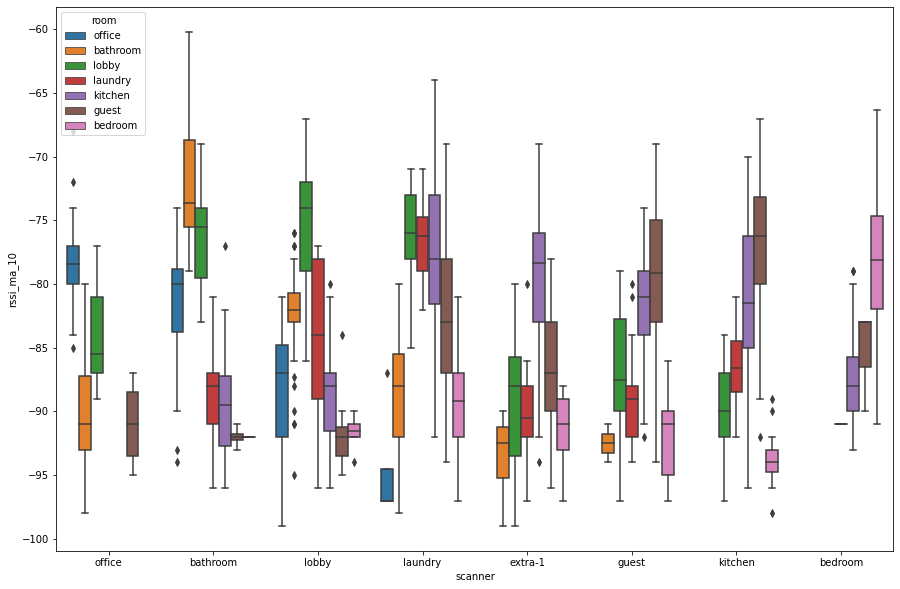

In [ ]:
f = plt.figure(figsize=(15, 10))
ax = f.add_subplot(111)
sbs.boxplot(data=data_df, x='scanner', y='rssi_ma_10', hue='room', ax=ax)

<AxesSubplot:xlabel='scanner', ylabel='rssi_ma_5'>

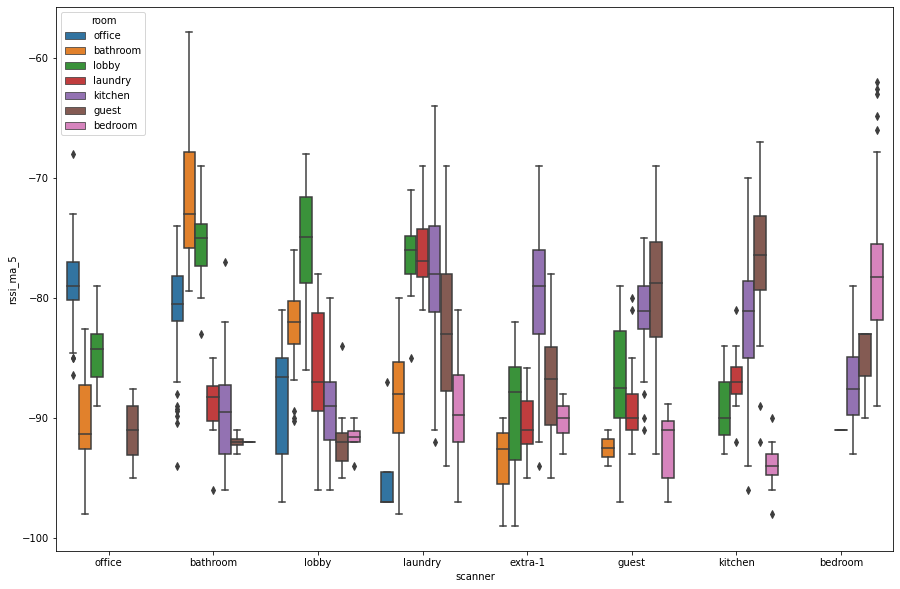

In [ ]:
f = plt.figure(figsize=(15, 10))
ax = f.add_subplot(111)
sbs.boxplot(data=data_df, x='scanner', y='rssi_ma_5', hue='room', ax=ax)
# sbs.violinplot(data=data_df,  x='scanner', y='rssi_ma_5', hue='room', color=".25", ax=ax)

<AxesSubplot:xlabel='scanner', ylabel='rssi_ma_2'>

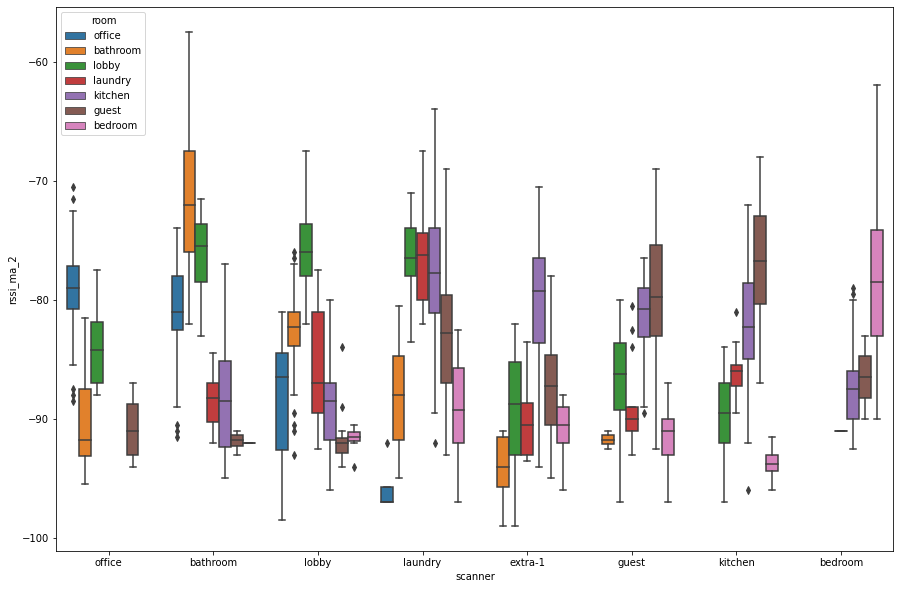

In [ ]:
f = plt.figure(figsize=(15, 10))
ax = f.add_subplot(111)
sbs.boxplot(data=data_df, x='scanner', y='rssi_ma_2', hue='room', ax=ax)

<AxesSubplot:xlabel='scanner', ylabel='rssi'>

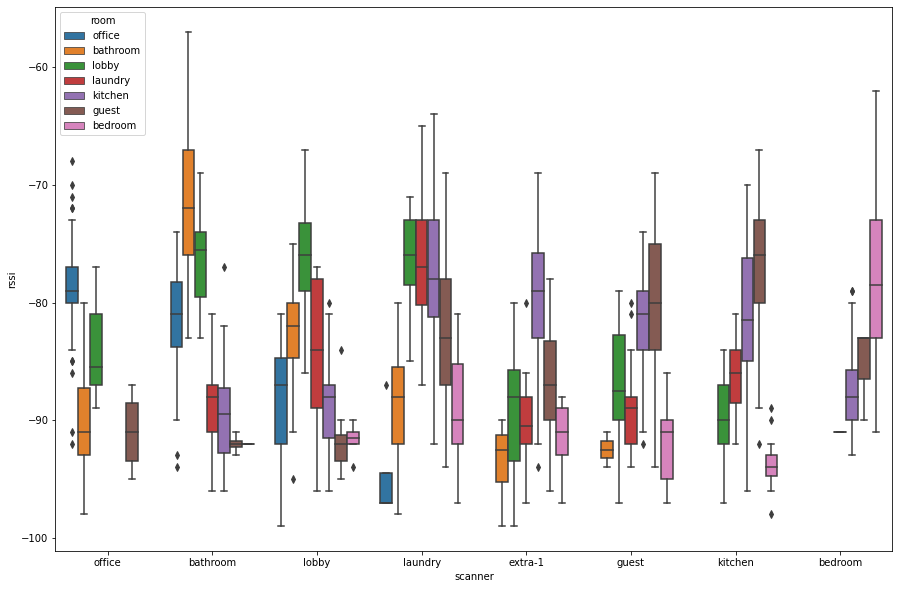

In [ ]:
f = plt.figure(figsize=(15, 10))
ax = f.add_subplot(111)
sbs.boxplot(data=data_df, x='scanner', y='rssi', hue='room', ax=ax)

## Moving Average против Kalman Filter
1. Сколько нужно шагов, чтобы Калман отразил изменение в 10 пунктов?
2. Как меняется RSSI при разных средних (2, 5, 10)?

<AxesSubplot:ylabel='rssi'>

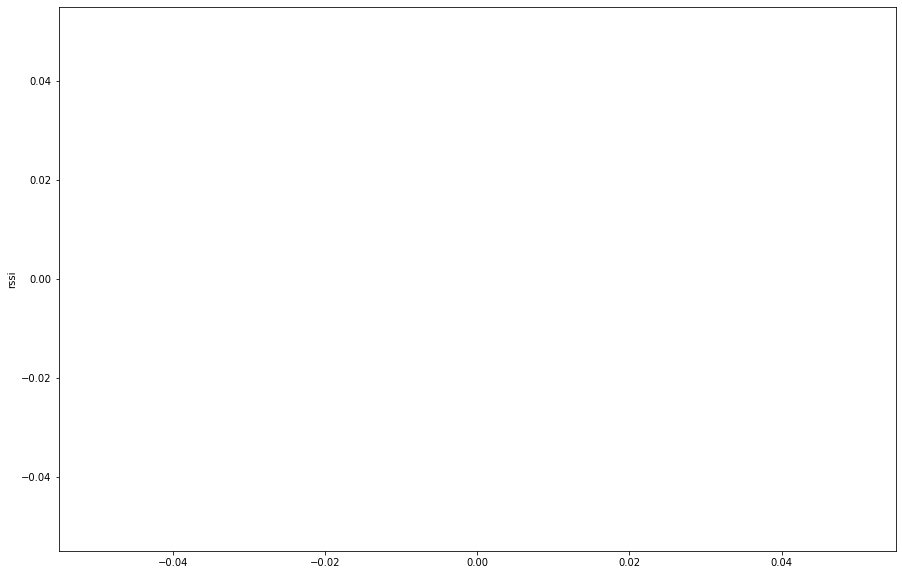

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(15, 10))
sbs.lineplot(data=data_df[data_df['scanner'] == 'guest'], x=[]  y='rssi', ax=axes)